# Graph visualization using igraph

This notebook demonstrates the use of the TrustGraph triple store API to fetch information from the knowledge graph. This information is then visualized using the igraph visualisation library. This notebook was executed against a running TrustGraph loaded with the UK legislation 2024 dataset.

In [1]:
!pip install trustgraph-base
!pip install igraph

In [2]:
!pip install cairocffi

In [3]:
import igraph as ig
import trustgraph.api as tg
from trustgraph.api import Uri, Literal

In [4]:
cli = tg.Api()

In [5]:
# Utility function, given a label works backward to find the URI of the graph node associated with that label
def get_entity(label):

    resp = cli.triples_query(
        p = Uri("http://www.w3.org/2000/01/rdf-schema#label"),
        o = Literal(label),
        limit = 1
    )

    # Return first row answer
    for row in resp:
        return row.s

    # Or raise exception
    raise RuntimeError("Couldn't resolve entity")

In [6]:
# Given an entity URI, find the label
def get_label(ent):

    if ent == "http://www.w3.org/2000/01/rdf-schema#label": return "label"
    if ent == "https://schema.org/subjectOf": return "subject of"
    if ent.startswith("https://trustgraph.ai/doc/"): return "source document"
    if ent == "http://www.w3.org/2004/02/skos/core#definition": return "definition"
    if ent == "https://schema.org/keywords": return "keyword"
    if ent == "https://schema.org/description": return "keyword"
    if ent == "http://www.w3.org/1999/02/22-rdf-syntax-ns#type": return "type"
    if ent == "https://schema.org/copyrightNotice": return "(c) notice"
    if ent == "https://schema.org/copyrightHolder": return "(c) held"
    if ent == "https://schema.org/copyrightYear": return "(c) year"

    if not ent.startswith("http"): return ent

    resp = cli.triples_query(
        s = ent,
        p = Uri("http://www.w3.org/2000/01/rdf-schema#label"),
        limit = 1
    )

    for row in resp:
        return row.o
        
    # If no label, just dump the entity, the URI can be its label
    return ent

In [7]:
# Given a graph node specified by URI, find related edges which start at that node
def get_related_edges(s, limit=20, follows=1):

    resp = cli.triples_query(
        s = s,
        limit = limit
    )

    res = [
        [s, row.p, row.o]
        for row in resp
    ]

    if follows > 1:
        seeds = [ r[2] for r in res ]
        for se in seeds:
            if se.startswith("http"):
                res.extend(get_related_edges(se, limit, follows - 1))

    return res

In [8]:
# Get some useful starting seeds
leaseholder = get_entity("leaseholder")
freeholder = get_entity("freehold")
resident = get_entity("resident")
lfra = get_entity("Leasehold and Freehold Reform Act 2024")

In [9]:
# Follow edges start at the seeds above to build a collection of statements
triples = []
triples.extend(get_related_edges(leaseholder, 10, 2))
triples.extend(get_related_edges(freeholder, 10, 2))
triples.extend(get_related_edges(resident, 10, 2))
triples.extend(get_related_edges(lfra, 10, 2))

In [10]:
len(triples)

99

## Visualization
Transform for graph vis

In [11]:
# Produces a list of entities which are sources and objects.  This list does not contain predicates
ents = list(set([t[0] for t in triples] + [t[2] for t in triples]))
vertex_labels = [ get_label(ent)[:25] for ent in ents]

In [12]:
# URI to ID mapping in both directions
id2uri = { ix: ent for ix, ent in enumerate(ents) }
uri2id = { ent: ix for ix, ent in enumerate(ents) }

# ID to human-readable label for nodes
id2name = { ix: name for ix, name in enumerate(vertex_labels) }

In [13]:
# Edge list, list of (subject, object) pairs
edges = [(uri2id[t[0]], uri2id[t[2]]) for t in triples]

In [14]:
# Mapping from edge to edge label
edge_labels = [ 
    get_label(t[1])[:20] for t in triples
]

In [15]:
g = ig.Graph(n=len(ents), edges=edges, directed=True)
g.vs["label"] = vertex_labels
g.vs["label_size"] = [10] * len(vertex_labels)
g.es["label"] = edge_labels
g.es["label_size"] = [10] * len(edge_labels)

In [16]:
print(g)

IGRAPH D--- 84 99 --
+ attr: label (v), label_size (v), label (e), label_size (e)
+ edges:
43->77 43->26 43->18 43->65 43->72 43->64 43->51 43->33 77->34 77->39 77->49
77->80 77->40 77->20 77->70 77->48 77->62 77->81 18->38 18->1 18->14 18->7
18->68 18->45 18->53 18->9 18->79 18->15 33->61 33->54 33->54 33->56 33->83
19->13 19->27 19->35 19->60 19->74 19->13 19->53 19->32 19->28 19->16 13->3
13->46 13->42 13->69 13->23 13->2 13->31 13->37 13->67 13->55 27->75 27->33
35->6 35->52 35->58 35->11 35->33 13->3 13->46 13->42 13->69 13->23 13->2
13->31 13->37 13->67 13->55 0->12 0->78 0->71 0->30 30->61 30->50 30->50
30->10 30->36 82->24 82->83 82->17 82->54 82->29 82->5 82->4 82->22 82->21
82->25 17->41 17->76 17->66 17->73 17->44 17->57 17->47 17->63 17->8 17->59


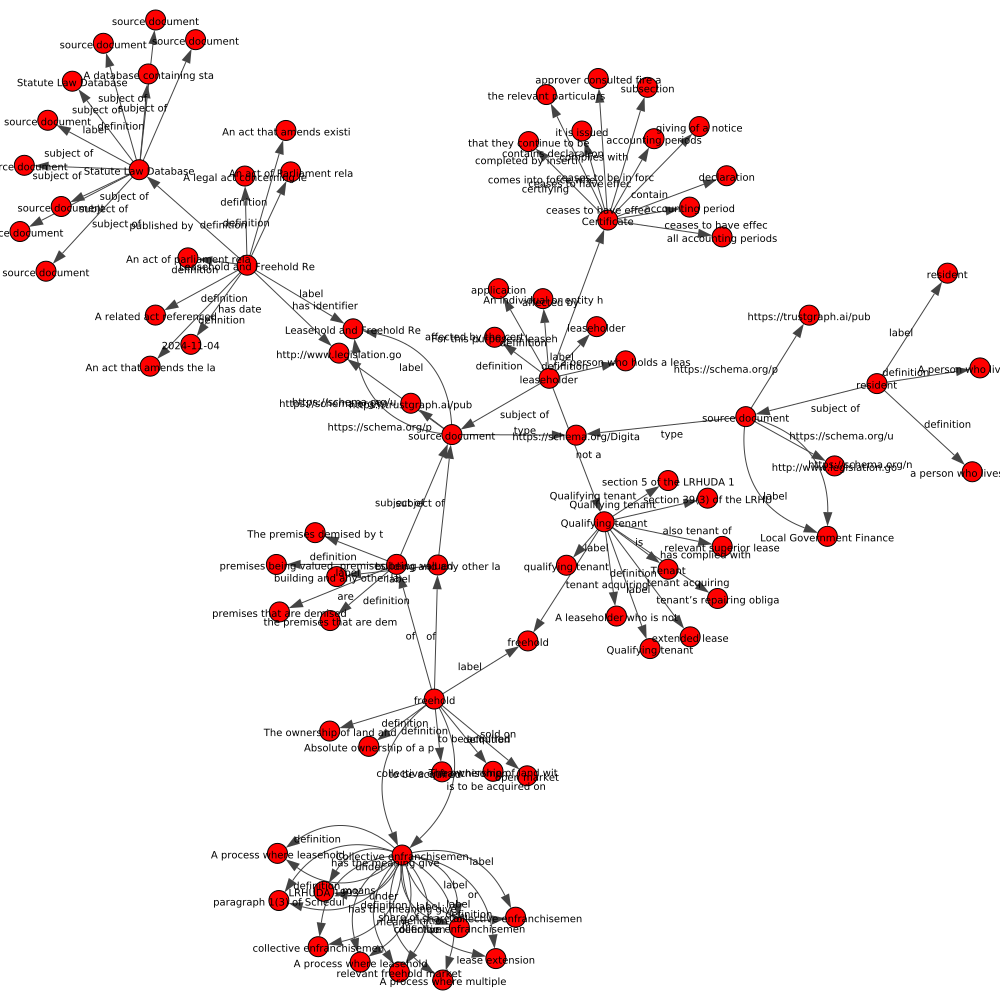

In [17]:
layout = g.layout("kk")

ig.plot(g, layout=layout, bbox=(0, 0, 1000, 1000))